# Classification of Point of interests

## Contexte 

Dans le contexte du projet de tableau de bord des espaces urbains africains (beta.dataspace.fr/city), les données d'OpenStreetMap ont été mises en forme pour apporter du sens aux chefs de projets AFD. Par exemple le tag "bus_station" désigne peut désigner les gares routières, ce qui a un intérêt lorsqu'on analyse des cartes.

Néanmoins cette information a peu de valeur car OSM reste une base de donne où la donnée est bruitée (les arrêts de bus normaux sont mélangés avec les gares routières, des agences de voyage se référencent comme gare routière), et incomplète (un chef de projet AFD s'attendrait à avoir plus d'informations sur cette gare routière).



## Plan d'expérience

* Récupération de l'ensemble des points référencées comme gare routière sur OpenStreetMap ( environ 1000 points en Afrique)
* Récupération de photos satellites des gares routières
* Etiquettage d'un petit set de points GPS via une plateforme de Crowdsourcing interne
* Entrainement d'un algorithme filtrant les faux positifs (points GPS classifiés comme gare routière alors qu'arrêt de bus ou agences de voyages)
* Entrainement d'un algorithme cherchant à déterminer plus de caractéristiques. Dans un premier temps bitumé/terre, et bâtiments/ pas de bâtiments. Lorsque le pipeline sera au point, l'utilisation d'images de drones ou d'images satellites achetées permettra l'estimation du type de flotte (taxi/minibus/bus).

## Enseignements

* OpenStreetMap à la fois complet (pas moins que Google Maps) et incomplet (énormément de points manquants sur l'Afrique, seulement 2Go de données). 
* Les manques sont surtout concentrés sur les zones les plus vulnérables ( Ex carte CartoDB)

### 1- Extractions des données

Voir le script getting_images.py

### 2- Augmentation des données 

Pour améliorer la qualité de l'analyse, nous allons augmenter le nombre de données, notamment avec des translations, du bruit etc...
Dans un premier temps, nous nous limiterons à pusieurs rotations à 90.

In [1]:
import os 
import skimage as sk 

# Get all raw images 
directory= os.listdir("img")





### 3- Extraction des descripteurs

Avant la classification, nous allons extraire les descripteurs.
Dans ce premier batch d'expériences, nous allons récuperer l'activation de certaines couches du réseau VG NET 16 en s'inspirant les instructions de Michel Blancard sur le blog de post suivant:  https://agd.data.gouv.fr/2016/06/27/un-reseau-de-neurones-pour-opensolarmap-23/

Ce sont les seuls descripteurs que nous intégrerons dans un premier temps. 

Nous en profitons pour créer un vecteur label, gare vs non gare.


In [104]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import numpy as np
import h5py

from keras import backend as K

        
def VGG_16_custom(weights_path):
    model = Sequential()

    model.add(ZeroPadding2D((1, 1), input_shape=(3, 96, 96), dim_ordering='th'))
    model.add(Convolution2D(64, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(64, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering='th'))

    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(128, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(128, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering='th'))
    
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(256, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(256, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(256, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering='th'))
   
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(512, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(512, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(512, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering='th'))
    
    '''
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(512, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(512, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(512, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering='th'))
    '''
    model.add(Flatten())

    f = h5py.File(weights_path,'r')
    
    print(f.attrs)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print('Model loaded.')

    return model

model = VGG_16_custom("/home/etienne/Documents/POI_classification/vgg16_weights.h5")
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')





<Attributes of HDF5 object at 140663579957656>
Model loaded.


In [105]:
from skimage import io

directory= os.listdir("img")
direc = ["img/"+x for x in directory]


def parse_title(title):
    vect= title.split("/")[-1].split(".")[0].split("-")
    img_id = vect[0]
    img_type = vect[-1]
    img_tag = []
    
    if len(vect) > 2:
        for i in range(len(vect)-2) :
            img_tag.append(vect[i+1])
            
    return img_id, img_type, img_tag
    


#Image loader
def loader(list_img):
    for i in range(len(list_img)):
        img = sk.io.imread(list_img[i])
        im = img[:-15:,:]
        [img_id, img_type, img_tag] = parse_title(list_img[i])
        yield [img_id, img_tag , im]
        for j in range(3):
            yield [img_id+str(j), img_tag, sk.transform.rotate(im, 90*(j+1))]


    


In [109]:


you = loader(direc)



In [110]:
from skimage import transform
def compute_cnn_features_list(img):
    img = sk.transform.resize(img, (96,96,3))
    im = img.copy().reshape((96, 96, 3)).copy()
    #plt.imshow(im.astype(np.uint8))
    im[:, :, 0] -= 103.939
    im[:, :, 1] -= 116.779
    im[:, :, 2] -= 123.68
    im = im.transpose((2, 0, 1))
    im = np.expand_dims(im, axis=0)
    cnn_features = model.predict(im)

    return cnn_features


n = len(directory)*4
img_id = np.zeros((n,))
label = np.zeros((n,), dtype="object")
features = np.zeros((n,18432))

for i in range(n):
    if (float(i)/10) == round(i/10):
        print(i,n)
    [img_i, labe, im] = you.next()
    img_id[i] = img_i
    label[i] = labe
    features[i,:] = compute_cnn_features_list(im)



(0, 300)
(10, 300)
(20, 300)
(30, 300)
(40, 300)
(50, 300)
(60, 300)
(70, 300)
(80, 300)
(90, 300)
(100, 300)
(110, 300)
(120, 300)
(130, 300)
(140, 300)
(150, 300)
(160, 300)
(170, 300)
(180, 300)
(190, 300)
(200, 300)
(210, 300)
(220, 300)
(230, 300)
(240, 300)
(250, 300)
(260, 300)
(270, 300)
(280, 300)
(290, 300)


In [100]:

def tag2label(tag, keyword):
    label = np.zeros((len(tag),), dtype="object")
    for i in range(len(tag)):
        if (keyword in tag[i]):
            label[i]= keyword
        else:
            label[i] = "false"
            
    return label

label2= tag2label(label, "batiment")
    

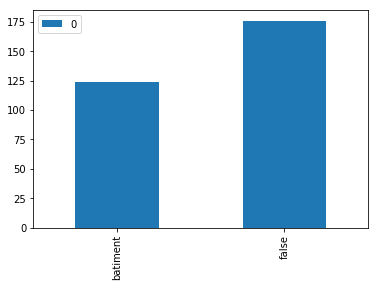

In [101]:
from sklearn.model_selection import train_test_split
'''
label[label == 'i'] = 'a'

label2 = np.zeros((len(label),))
label2[label == 'r'] = 1
'''
X_train, X_test, y_train, y_test = train_test_split(features, label2, test_size=0.1, random_state=0)

from matplotlib import pyplot as plt
%matplotlib inline
import pandas
from collections import Counter
letter_counts = Counter(label2)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')




In [102]:
from sklearn.linear_model import LogisticRegression
import time

n_C = 30
C_list = np.logspace(-10, 10, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = LogisticRegression(penalty='l2', C=C)
    t = time.time()
    model.fit(X_train, y_train)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(X_test)

    errors[i] = float((y_test!=predictions).sum())/len(y_test)


LR took 0.337421 seconds.
LR took 0.511205 seconds.
LR took 0.809492 seconds.
LR took 1.435164 seconds.
LR took 1.708947 seconds.
LR took 2.407636 seconds.
LR took 2.412380 seconds.
LR took 2.374750 seconds.
LR took 2.371878 seconds.
LR took 2.376181 seconds.
LR took 2.760183 seconds.
LR took 2.657372 seconds.
LR took 2.606982 seconds.
LR took 2.376634 seconds.
LR took 2.464220 seconds.
LR took 2.547193 seconds.
LR took 2.427666 seconds.
LR took 2.544656 seconds.
LR took 2.415562 seconds.
LR took 2.664352 seconds.
LR took 2.650775 seconds.
LR took 2.390611 seconds.
LR took 2.395807 seconds.
LR took 2.394000 seconds.
LR took 2.390781 seconds.
LR took 2.387709 seconds.
LR took 3.057099 seconds.
LR took 2.628762 seconds.
LR took 2.388444 seconds.
LR took 2.393057 seconds.


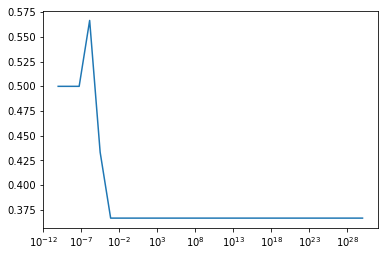

In [103]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(C_list, errors)
plt.xscale('log')


In [62]:
i_opt = np.argmin(errors)
C_opt = C_list[i_opt] #0.000018#
print('optimal C : %f'%C_opt)
model = LogisticRegression(penalty='l2', C=C_opt)
t = time.time()
model.fit(X_train, y_train)
print("LR took %f seconds."%(time.time()-t))
predictions = model.predict(X_test)

errors[i] = float((y_test!=predictions).sum())/len(y_test)

optimal C : 572236.765935
LR took 0.107392 seconds.


['false' 'bitume' 'bitume' 'bitume' 'false' 'false' 'false' 'false' 'false'
 'bitume' 'bitume' 'false' 'bitume' 'false' 'bitume' 'bitume' 'bitume'
 'bitume' 'bitume' 'false' 'bitume' 'bitume' 'false' 'false' 'false'
 'bitume' 'bitume' 'bitume' 'bitume' 'bitume' 'false' 'false' 'false'
 'bitume' 'false' 'bitume' 'false' 'false' 'false' 'bitume' 'false'
 'bitume' 'bitume' 'bitume' 'false' 'false' 'false' 'false' 'false' 'false'
 'false' 'bitume' 'bitume' 'bitume' 'false' 'false' 'bitume' 'false'
 'false' 'false' 'false' 'false' 'false' 'false' 'false' 'false' 'bitume'
 'false' 'bitume' 'false' 'false' 'false' 'false' 'false' 'false' 'bitume'
 'false' 'bitume' 'bitume' 'false' 'false' 'bitume' 'bitume' 'false'
 'bitume' 'false' 'bitume' 'false' 'bitume' 'bitume' 'false' 'bitume'
 'false' 'false' 'bitume' 'bitume' 'bitume' 'bitume' 'bitume']
['false' 'bitume' 'false' 'false' 'false' 'bitume' 'bitume' 'false' 'false'
 'bitume' 'bitume' 'false' 'bitume' 'false' 'false' 'false' 'false'
 'bitu

ValueError: Data is not binary and pos_label is not specified